

# <p style="background-color:#344ceb;font-family:Serif;color:#FFF9ED;font-size:120%;text-align:center;border-radius:10px 10px 10px 10px;">Deep Learning Based Architecture for Entity Extraction from Covid Related Documents.</p>


1. The traditional ner models give a lot of restriction when we do not have sufficient for the domain specific ner task.We care about to train a reliable model for domain specific ner task.

2. Transfer learning allows us to deal with these scenarios by leveraging the already existing labeled data of some related task or domain. We try to store this knowledge gained in solving the source task in the source domain and apply it to our problem of interest.

3. In this work, I have utilise  **BI-LSTM** model with **CNN and CRF**. 


4. All the model performance for comparision has been published. Check them out [here](https://doi.org/10.1007/978-3-031-13150-9_33) 



 <a id='top'></a>
 <div class="list-group" id="list-tab" role="tablist">
 <p style="background-color:#344ceb;font-family:Serif;color:#FFF9ED;font-size:200%;text-align:center;border-radius:10px 10px;">TABLE OF CONTENTS</p>   
    
* [1. Library Installation](#1)
    
* [2. Library Import](#2)
    
* [3. Data Set Processing](#3)
    
* [4. Pretrained Embeddings](#4)   
    
* [5. Char Embeddings](#5) 
      
* [6.Ner Modeling](#6)
    
* [7. Model architecture](#7)
    
* [8. Setting Hyperparameter](#8)  
    
* [9. Model Summary](#9)
    
* [10. Training](#10)

* [11. Model Evaluation](#11)
    
* [12. Result](#12)
    
* [13. References](#13)


# **<span style="color:#344ceb;"> Library Installations</span>**

In [1]:
!pip install keras_preprocessing
!pip install tensorflow-addons
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=e4b2bda04a86bbe15caa4b21ea4481f5243102414ad83b3eb8e0dc44ccf2d416
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


# **<span style="color:#344ceb;">Library Import</span>**

In [2]:
import pandas as pd
import numpy as np
from time import sleep
from tqdm import tqdm
import keras
import tensorflow as tf
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras import regularizers
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.layers import Dense
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomUniform
from keras import regularizers
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Conv1D
from keras.layers import Flatten
from keras.layers import concatenate
from keras.layers import MaxPooling1D
from keras.layers import InputLayer
from tensorflow_addons.layers import CRF
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow_addons.text.crf_wrapper import CRFModelWrapper


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# **<span style="color:#344ceb;">DATASET CORD-19</span>**

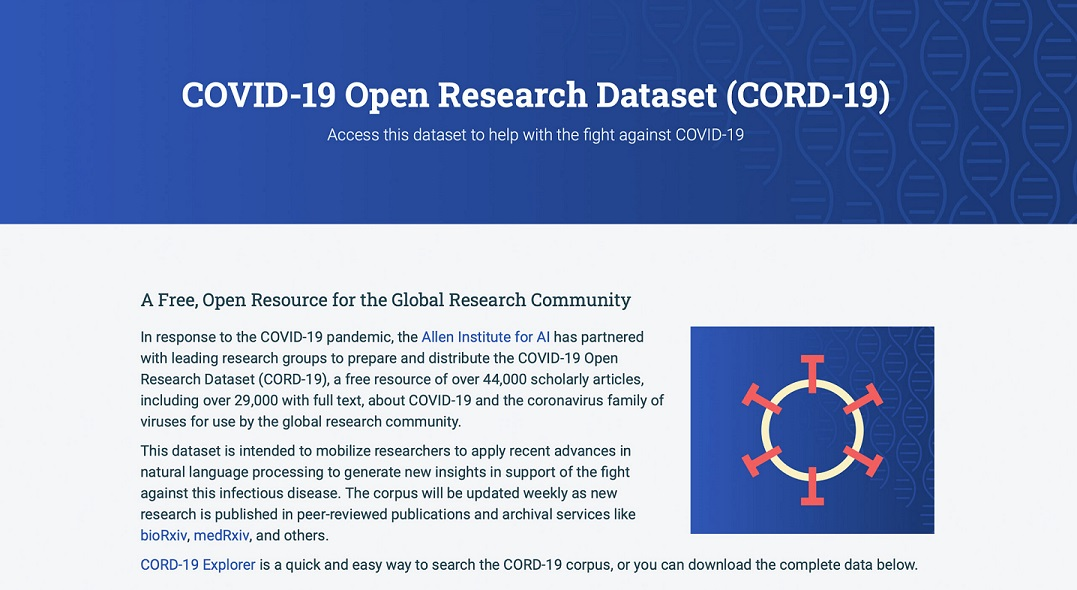

In [3]:
# Reading dataset
data = pd.read_parquet('/kaggle/input/covid-ner-data-set/cord-ner-full.parquet.gzip')

In [4]:
data.head()

,word,entity,sentence
0,angiotensin-converting,B-GENE_OR_GENOME,0
1,enzyme,I-GENE_OR_GENOME,0
2,2,I-GENE_OR_GENOME,0
3,ace2,B-GENE_OR_GENOME,0
4,as,Other,0


In [5]:
# Renaming columns of dataset.
data.rename(columns={"word": "Word", "entity": "Tag","sentence":"Sentence"},inplace=True)

In [6]:
# Taking subset of dataset/
data = data[:len(data)//12]

In [7]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences


class ContextNER:

    __X, __y = None, None
    X_array, y_array = None, None

    word2idx, idx2word = None, None
    tag2idx, idx2tag = None, None
    y_array_normal = None

    def __init__(self, df, all_words, max_len=None):

        self.__df = df

        self.all_words = set(all_words)
        self.all_tags = set(df.Tag.values)

        self.sentences = self.__build_sentences()

        self.num_words = len(self.all_words) + 2
        self.num_tags = len(self.all_tags) + 1

        if max_len:
            self.max_len = max_len
        else:
            self.max_len = self._get_maxlen()

        self.__build_Xy()
        self.__build_parsers()
        self.__parser_arrays()

    def _get_maxlen(self):
        return max([len(x) for x in self.sentences]) + 1

    def __build_sentences(self):

        return [x for x in self.__df.groupby('Sentence').apply(
            lambda xdef: [x for x in zip(
                xdef.Word.values,
                xdef.Tag.values
            )]
        )]

    def __build_Xy(self):

        self.__X = [[word for word, __ in value] for value in self.sentences]
        self.__y = [[tag for __, tag in value] for value in self.sentences]

    def __build_parsers(self):

        self.word2idx = {value: idx + 2 for idx,
                         value in enumerate(self.all_words)}
        self.word2idx["UNK"] = 1  
        self.word2idx["PAD"] = 0  

        # Converte um index em Word
        self.idx2word = {idx: value for value, idx in self.word2idx.items()}

        # Converte Tag em ìndice
        self.tag2idx = {value: idx + 1 for idx,
                        value in enumerate(self.all_tags)}
        self.tag2idx["PAD"] = 0  

        self.idx2tag = {idx: value for value, idx in self.tag2idx.items()}

    def parser2categorical(self, y_pred, y_true):

        pred_tag = [[self.idx2tag[idx] for idx in row] for row in y_pred]
        y_true_tag = [[self.idx2tag[idx] for idx in row] for row in y_true]

        return pred_tag, y_true_tag

    def __parser_arrays(self):

        tmp_X = [[self.word2idx[index] for index in value]
                 for value in self.__X]
        tmp_y = [[self.tag2idx[index] for index in value]
                 for value in self.__y]

        self.X_array = pad_sequences(maxlen=self.max_len,
                                     sequences=tmp_X,
                                     padding="post",
                                     value=0)

        y_pad = pad_sequences(maxlen=self.max_len,
                              sequences=tmp_y,
                              padding="post",
                              value=0)

        self.y_array_normal = y_pad
        self.y_array = np.array(
            [to_categorical(index, num_classes=self.num_tags, dtype='int8') for index in y_pad])


In [8]:
def build_matrix_embeddings(path, num_tokens, embedding_dim, word_index):
    """
        Function to load pre-trained files into memory
        
    """

    hits, misses = 0, 0
    embeddings_index = {}

    print('Loading file...')

    sleep(0.5)

    for line in tqdm(open(path, encoding='utf-8')):
        word, coefs = line.split(maxsplit=1)
        embeddings_index[word] = np.fromstring(coefs, "f", sep=" ")

    print("Found %s Word Vectors." % len(embeddings_index))

    sleep(0.5)

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))

    for word, i in tqdm(word_index.items()):
        if i >= num_tokens:
            continue
        try:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                hits += 1
            else:
                embedding_vector = embeddings_index.get(str(word).lower())
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                    hits += 1
                else:
                    embedding_vector = embeddings_index.get(str(word).upper())
                    if embedding_vector is not None:
                        embedding_matrix[i] = embedding_vector
                        hits += 1
                misses += 1
        except:
            embedding_matrix[i] = embeddings_index.get('UNK')

    print("Converted: %d Tokens | Lost: %d Tokens" % (hits, misses))

    return embedding_matrix


In [9]:
ner_aux = ContextNER(data, data.Word.to_list())

In [10]:
del data

<a id="6"></a>
## <p style="background-color:#344ceb;font-family:Serif;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> Loading the pretrained Embedding</p>
#### 

In [11]:
%%time
file_path = '/kaggle/input/glove6b100dtxt/glove.6B.100d.txt'

glove_embeddings = \
build_matrix_embeddings(path=file_path,
                        num_tokens=ner_aux.num_words, 
                        embedding_dim=100,
                        word_index=ner_aux.word2idx)

Loading file...


400000it [00:08, 48821.24it/s]


Found 400000 Word Vectors.


100%|██████████| 166333/166333 [00:00<00:00, 680056.08it/s]

Converted: 43274 Tokens | Lost: 123061 Tokens
CPU times: user 7.52 s, sys: 301 ms, total: 7.82 s
Wall time: 9.52 s


In [12]:
from sklearn.model_selection import train_test_split

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST  = train_test_split(ner_aux.X_array,ner_aux.y_array,test_size=0.3)

In [13]:
X_TRAIN = np.asarray(X_TRAIN).astype(np.float32)
X_TEST = np.asarray(X_TEST).astype(np.float32)
Y_TRAIN = np.asarray(Y_TRAIN).astype(np.float32)
Y_TEST = np.asarray(Y_TEST).astype(np.float32)

<a id="6"></a>
## <p style="background-color:#344ceb;font-family:Serif;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> Char Embeddings</p>
#### 

In [14]:
#Chars Embeddings/features
def get_X_char(sentences, max_len,  max_len_char, char2idx):
    X_char = []
    for sentence in tqdm(sentences):
        sent_seq = []
        for i in range(max_len):
            word_seq = []
            for j in range(max_len_char):
                try:
                    word_seq.append(char2idx.get(sentence[i][0][j]))
                except:
                    word_seq.append(char2idx.get("PAD"))
            sent_seq.append(word_seq)
        X_char.append(np.array(sent_seq))

    return np.asarray(X_char)

In [15]:
def save_best_model(path_folder, file_name, metric):

    if metric == 'f1':
        mode = 'max'
        
    elif metric == 'val_loss':
        mode = 'min'
        
    return ModelCheckpoint(path_folder + file_name + '.h5',
                           monitor=metric,
                           mode=mode,
                           verbose=1,
                           save_best_only=True)

In [16]:
def show_true_pred(index, true_tag, pred_tag, idx2word, ner_source):

    word_parser_idx = idx2word
    TEST = ner_source[index]

    print("{:25}   {:10}   {}".format("Word", "True", "Pred"))
    print("=" * 50)

    for word, true, pred in zip([word_parser_idx[x] for x in TEST],
                                 true_tag[index],
                                 pred_tag[index]):
        if pred != 'PAD':
            print("{:25}   {:10}    {}".format(word, true, pred))

In [17]:
chars = set([w_i for w in ner_aux.all_words for w_i in str(w)])
n_chars = len(chars) + 2
max_len_char = 10

In [18]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0
idx2char = {i: c for c, i in char2idx.items()}

In [19]:
X_train_char_X = [[ner_aux.idx2word[x] for x in sent] for sent in X_TRAIN]
X_test_char_X = [[ner_aux.idx2word[x] for x in sent] for sent in X_TEST]

In [20]:
X_TRAIN_CHAR = get_X_char(X_train_char_X, ner_aux.max_len, max_len_char, char2idx)
X_TEST_CHAR = get_X_char(X_test_char_X, ner_aux.max_len, max_len_char, char2idx)

100%|██████████| 3567/3567 [00:10<00:00, 344.70it/s]


# **<span style="color:#344ceb;"> NER MODELING</span>**

# **<span style="color:#344ceb;"> Model Architecture </span>**

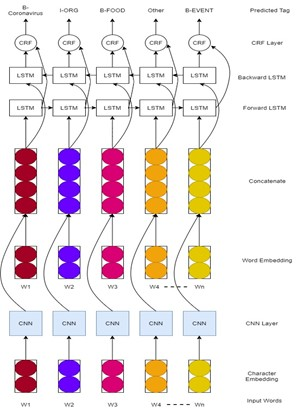
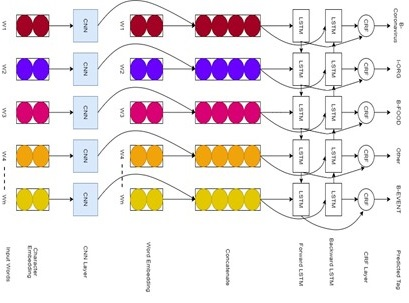

In [21]:
def BiLSTM_CNN(isa_crf=True,words_weights=None,pre_trained=False,max_len=None,max_len_char=None,
               num_words=None,num_tags=None,n_chars=None,kernel_size=None,filter_size=None,
               hiden_layer=128,is_trainable=False,l2_reg=1e-6,learning_rate=0.001,dropout=0.2):

    # Char Embbedings
    chars_input = Input(shape=(max_len, max_len_char,), dtype='float32')
    chars_embed = Embedding(input_dim=n_chars,
                            output_dim=max_len_char,
                            embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5))(chars_input)

    chars_embed = TimeDistributed(Dropout(rate=dropout))(chars_embed)

    # Cnn Features
    chars_embed = TimeDistributed(Conv1D(kernel_size=kernel_size,
                                         filters=filter_size,
                                         padding='same',
                                         activation='tanh',
                                         strides=1))(chars_embed)

    chars_embed = TimeDistributed(MaxPooling1D(
        pool_size=max_len_char))(chars_embed)
    chars_embed = TimeDistributed(Flatten())(chars_embed)

    # Word Embbedings
    words_input = Input(shape=(max_len,), dtype='float32')
    words_embed = Embedding(input_dim=words_weights.shape[0],
                            output_dim=words_weights.shape[1],
                            weights=[words_weights],
                            trainable=is_trainable)(words_input)

    x = concatenate([words_embed, chars_embed])

    BiLSTM = Bidirectional(LSTM(units=hiden_layer // 2,
                                return_sequences=True,
                                recurrent_dropout=0.1,
                                kernel_regularizer=regularizers.l2(l2_reg)))(x)

    BiLSTM = TimeDistributed(Dropout(rate=dropout))(BiLSTM)
    BiLSTM = TimeDistributed(Dense(units=hiden_layer,
                                   activation='relu'))(BiLSTM)

#     crf = CRF(num_tags)
#     decoded_sequence, potentials, sequence_length, chain_kernel = crf(BiLSTM)

    BiLSTM = Dense(units=num_tags, activation='softmax')(BiLSTM)
    
    model = Model(inputs=[words_input, chars_input],
                  outputs=BiLSTM)
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

#     model.compile(optimizer="rmsprop", loss='categorical_crossentropy',metrics=['accuracy'])
    
    return model


<a id="7"></a>
## <p style="background-color:#344ceb;font-family:Serif;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> Setting Hyper Parameters</p>
#### 

In [22]:
EPOCHS = 5
DROPOUT = 0.2
BATCH_SIZE = 128
LEARNING_RATE = 0.01
HIDEN_LAYER = 128
L2_REG = 1e-9
VALIDATION_SPLIT = 0.1

FILTER_SIZE = 30
KERNEL_SIZE = 3

In [23]:
model = BiLSTM_CNN(isa_crf=True,
                   words_weights=glove_embeddings,
                   pre_trained=True,
                   max_len=ner_aux.max_len,
                   max_len_char=max_len_char,
                   n_chars=n_chars,
                   num_words=ner_aux.num_words,
                   num_tags=ner_aux.num_tags,
                   kernel_size=KERNEL_SIZE,
                   filter_size=FILTER_SIZE,
                   hiden_layer=HIDEN_LAYER,
                   is_trainable=True,
                   l2_reg=L2_REG,
                   learning_rate=LEARNING_RATE,
                   dropout=DROPOUT)

<a id="7"></a>
## <p style="background-color:#344ceb;font-family:Serif;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> Model Summary</p>

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 513, 10)]    0           []                               
                                                                                                  
 embedding (Embedding)          (None, 513, 10, 10)  7080        ['input_1[0][0]']                
                                                                                                  
 time_distributed (TimeDistribu  (None, 513, 10, 10)  0          ['embedding[0][0]']              
 ted)                                                                                             
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 513, 10, 30)  930        ['time_distributed[0][0]']   

<a id="7"></a>
## <p style="background-color:#344ceb;font-family:Serif;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> Training the model</p>


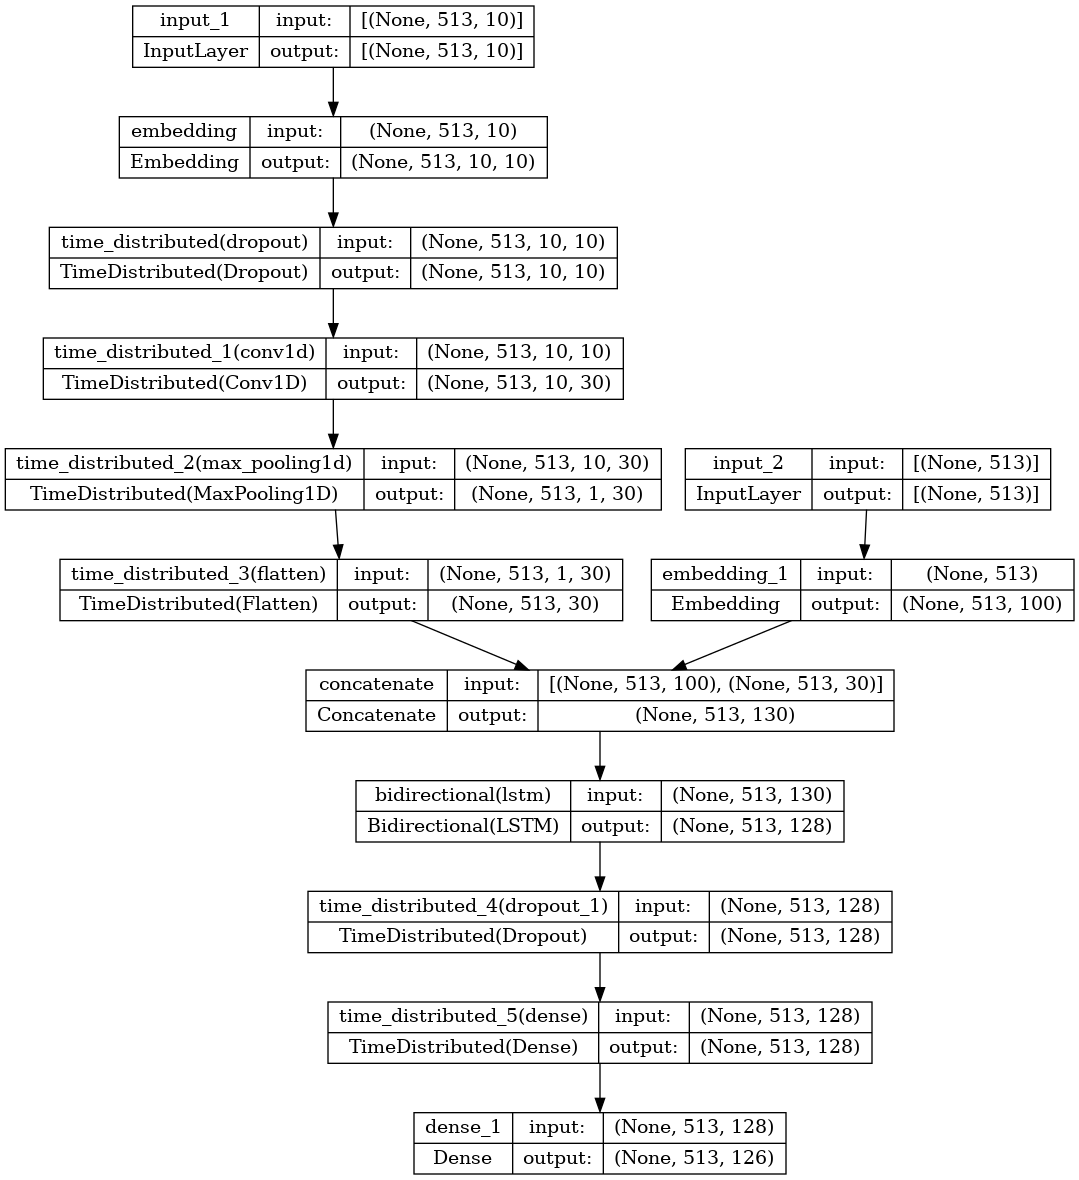

In [25]:
from keras.utils import plot_model
plot_model(model,to_file='model_bilstm_crf.png',
           show_shapes=True,
           show_layer_names=True,
           expand_nested=True)

In [26]:
%%time
callbacks = keras.callbacks.EarlyStopping(monitor='categorical_crossentropy', patience=2,
                         verbose=1, mode='max', restore_best_weights=True)
X_TRAIN_CHAR = np.asarray(X_TRAIN_CHAR).astype(np.float32)
History = \
model.fit([X_TRAIN, X_TRAIN_CHAR],
           Y_TRAIN, 
           batch_size=BATCH_SIZE, 
           epochs=EPOCHS, 
           validation_split=VALIDATION_SPLIT,
           callbacks=[callbacks])


Epoch 1/5
59/59 [==============================] - 244s 4s/step - loss: 1.0196 - accuracy: 0.7993 - val_loss: 0.6679 - val_accuracy: 0.8391
Epoch 2/5
59/59 [==============================] - 232s 4s/step - loss: 0.5447 - accuracy: 0.8655 - val_loss: 0.4335 - val_accuracy: 0.8890
Epoch 3/5
59/59 [==============================] - 231s 4s/step - loss: 0.3911 - accuracy: 0.8968 - val_loss: 0.3632 - val_accuracy: 0.9041
Epoch 4/5
59/59 [==============================] - 228s 4s/step - loss: 0.3218 - accuracy: 0.9118 - val_loss: 0.3330 - val_accuracy: 0.9109
Epoch 5/5
59/59 [==============================] - 228s 4s/step - loss: 0.2789 - accuracy: 0.9214 - val_loss: 0.3201 - val_accuracy: 0.9148
CPU times: user 27min 41s, sys: 3min 21s, total: 31min 2s
Wall time: 19min 32s


In [27]:
import numpy as np
from keras.callbacks import Callback
from seqeval.metrics import f1_score
from seqeval.metrics import recall_score
from seqeval.metrics import accuracy_score
from seqeval.metrics import precision_score
from seqeval.metrics import classification_report

class F1Metrics(Callback):

    def __init__(self, id2label, pad_value=0, validation_data=None, digits=4):

        super(F1Metrics, self).__init__()
        
        self.id2label = id2label
        self.pad_value = pad_value
        self.validation_data = validation_data
        self.digits = digits
        self.is_fit = validation_data is None

    def convert_idx_to_name(self, y, array_indexes):

        y = [[self.id2label[idx] for idx in row[row_indexes]] for
             row, row_indexes in zip(y, array_indexes)]
        return y

    def predict(self, X, y):

        y_pred = self.model.predict_on_batch(X)

        # reduce dimension.
        y_true = np.argmax(y, -1)
        y_pred = np.argmax(y_pred, -1)

        non_pad_indexes = [np.nonzero(y_true_row != self.pad_value)[0] for y_true_row in y_true]

        y_true = self.convert_idx_to_name(y_true, non_pad_indexes)
        y_pred = self.convert_idx_to_name(y_pred, non_pad_indexes)

        return y_true, y_pred

    def score(self, y_true, y_pred):
        
        f_score = f1_score(y_true, y_pred)
        r_score = recall_score(y_true, y_pred)
        p_score = precision_score(y_true, y_pred)
        
        print('NER Metrics > precision_score: {:04.2f}  --  recall_score: {:04.2f}  --  f1_score: {:04.2f}'.format(p_score, r_score, f_score))
        
        return f_score, r_score, p_score

    def on_epoch_end(self, epoch, logs={}):
        
        if self.is_fit:
            self.on_epoch_end_fit(epoch, logs)
        else:
            self.on_epoch_end_fit_generator(epoch, logs)

    def on_epoch_end_fit(self, epoch, logs={}):
        
        X = self.validation_data[0]
        y = self.validation_data[1]
        y_true, y_pred = self.predict(X, y)

        f_score,\
        r_score,\
        p_score = self.score(y_true, y_pred)
        
        logs['f1'], logs['recall'], logs['precision'] = f_score, r_score, p_score
        

    def on_epoch_end_fit_generator(self, epoch, logs={}):
        
        y_true = []
        y_pred = []
        
        for X, y in self.validation_data:
            y_true_batch, y_pred_batch = self.predict(X, y)
            y_true.extend(y_true_batch)
            y_pred.extend(y_pred_batch)

        f_score,\
        r_score,\
        p_score = self.score(y_true, y_pred)
        
        logs['f1'], logs['recall'], logs['precision'] = f_score, r_score, p_score
        
        
        
def all_metrics(pred_tag, true_tag):

    print(classification_report(pred_tag, true_tag))
    print('=' * 25)
    print("Precision: \t", precision_score(pred_tag, true_tag))
    print("Recall: \t", recall_score(pred_tag, true_tag))
    print("F1: \t\t", f1_score(pred_tag, true_tag))
    
def all_metrics_fold(pred_tag, true_tag):

    print('=' * 25)
    print("Precision: \t", precision_score(pred_tag, true_tag))
    print("Recall: \t", recall_score(pred_tag, true_tag))
    print("F1: \t\t", f1_score(pred_tag, true_tag))

<a id="9"></a>
## <p style="background-color:#344ceb;font-family:Serif;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> Evaluating the model</p>


In [28]:
X_TEST = np.asarray(X_TEST).astype(np.float32)
X_TEST_CHAR = np.asarray(X_TEST_CHAR).astype(np.float32)

In [29]:
del X_TRAIN, 
del X_TRAIN_CHAR
del Y_TRAIN

In [30]:
y_pred, y_true = \
np.argmax(model.predict([X_TEST, X_TEST_CHAR], verbose=1, batch_size=64), axis=-1), \
np.argmax(Y_TEST, -1)

pred_tag, true_tag = \
ner_aux.parser2categorical(y_pred, y_true) 

all_metrics(pred_tag, true_tag)

56/56 [==============================] - 17s 289ms/step


/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Other seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PAD seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                     precision    recall  f1-score   support

                                 AD       1.00      1.00      1.00      3567
               ANATOMICAL_STRUCTURE       0.65      0.67      0.66       266
                           ARCHAEON       0.00      0.00      0.00         0
                          BACTERIUM       0.74      0.74      0.74       213
 BODY_PART_ORGAN_OR_ORGAN_COMPONENT       0.75      0.70      0.72      2777
                     BODY_SUBSTANCE       0.93      0.78      0.85      1083
                           CARDINAL       0.81      0.79      0.80     19348
                               CELL       0.72      0.61      0.66     10442
                     CELL_COMPONENT       0.67      0.63      0.65      6143
                      CELL_FUNCTION       0.90      0.87      0.88       978
      CELL_OR_MOLECULAR_DYSFUNCTION       0.97      0.82      0.89      1050
                           CHEMICAL       0.64      0.66      0.65     4721

In [31]:
def show_true_pred(index, true_tag, pred_tag, idx2word, ner_source):

    word_parser_idx = idx2word
    TEST = ner_source[index]

    print("{:25}   {:10}   {}".format("Word", "True", "Pred"))
    print("=" * 50)

    for word, true, pred in zip([word_parser_idx[x] for x in TEST[:50]],
                                 true_tag[index],
                                 pred_tag[index]):
        if pred != 'PAD':
            print("{:25}   {:10}    {}".format(word, true, pred))
            

<a id="10"></a>
## <p style="background-color:#344ceb;font-family:Serif;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> Result Report</p>


In [32]:
for index in range(2):
    show_true_pred(index, pred_tag, true_tag, ner_aux.idx2word, X_TEST)

Word                        True         Pred
of                          Other         Other
the                         Other         Other
results                     Other         Other
of                          Other         Other
genetic                     Other         B-LOC
association                 I-ORG         I-LOC
studies                     Other         I-LOC
for                         Other         Other
complex                     Other         Other
diseases                    I-DISEASE_OR_SYNDROME    Other
[18,                        Other         Other
19                          B-DATE        B-DATE
.                           Other         Other
this                        Other         Other
inconsistency               Other         Other
may                         Other         Other
be                          Other         Other
attributable                Other         Other
to                          Other         Other
the                         Ot

<a id="11"></a>
## <p style="background-color:#344ceb;font-family:Serif;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> References</p>

1. Wang, X., Song, X., Li, B., Guan, Y., Han, J.: Comprehensive named entity recognition on cord-19 with distant or weak supervision. arXiv preprint arXiv:2003.12218 (2020)

2. Cho, H., Lee, H.: Biomedical named entity recognition using deep neural networks with contextual information. BMC Bioinf. 20, 735 (2019). https://doi.org/10.1186/s12859-019-3321-4

3. Chalapathy, R., Borzeshi, E.Z., Piccardi, M.: Bidirectional LSTM-CRF for clinical concept extraction. arXiv preprint arXiv:1611.08373 (2016)

4. Gridach, M.: Character-level neural network for biomedical named entity recognition. J. Biomed. Inform. 70, 85–91 (2017)

5. Wang, Y., Rastegar-Mojarad, M., Komandur-Elayavilli, R., Liu, H.: Leveraging word embeddings and medical entity extraction for biomedical dataset retrieval using unstructured texts. Database 2017, bax091 (2017)

6. Song, H.-J., Jo, B.-C., Park, C.-Y., Kim, J.-D., Kim, Y.-S.: Comparison of named entity recognition methodologies in biomedical documents. BioMed. Eng. OnLine 17(S2), 158 (2018). https://doi.org/10.1186/s12938-018-0573-6

7. Leser, U., Hakenberg, J.: What makes a gene name? Named entity recognition in the biomedical literature. Brief Bioinform. 6(4), 357–369 (2005). https://doi.org/10.1093/bib/6.4.357. PMID: 16420734

8. Luo, G., Huang, X., Lin, C.-Y., Ni, Z.: Joint entity recognition and disambiguation. In: Proceedings of the 2015 Conference on Empirical Methods in Natural Language Processing, pp. 879–888 (2015)


9. Wang, D., Cui, P., Zhu, W.: Structural deep network embedding. In: Proceedings of the 22nd ACM SIGKDD international conference on Knowledge discovery and data mining, pp. 1225–1234 (2016)

10. Rout, R.K., Hassan, S.S., Sheikh, S., Umer, S., Sahoo, K.S., Gandomi, A.H.: Feature-extraction and analysis based on spatial distribution of amino acids for SARS-CoV-2 Protein sequences. Comput. Biol. Med. 141, 105024 (2022). https://doi.org/10.1016/j.compbiomed.2021.105024

11. Hassan, S.K.S., et al.: A vicenary analysis of SARS-CoV-2 genomes. Comput. Mater. Continua 69, 3477–3493 (2021)

12. Zhao, Z., et al.: Disease named entity recognition from biomedical literature using a novel convolutional neural network. BMC Med. Genomics. 10(5), 73 (2017)


13. Chieu, H.L., Ng, H.T.: Named entity recognition: A maximum entropy approach using global information. In: Proceedings of the 19th International Conference on Computational Linguistics—vol. 1. Association for Computational Linguistics, Pennsylvania, p. 1–7 (2002)

14. Huang, Z., Xu, W., Yu, K.: Bidirectional LSTM–CRF models for sequence tagging. arXiv preprint arXiv:1508.01991 (2015)

15. Hochreiter, S., Schmidhuber, J.: Long short-term memory. Neural Comput. 9(8), 1735–1780 (1997)

16. Madhu, G., et al.: Imperative dynamic routing between capsules network for malaria classification. Comput., Mater. Continua 68(1), 903–919 (2021)


<center><h1 style = "font-size:25px;font-family: Comic Sans MS">  Feel free to comment if you have any queries:)</h1></center>

<center><h1 style = "font-size:25px;font-family: Comic Sans MS">  Also currently this notebook needs lots of improvements and I am open to suggestions.</h1></center>

 ### This Notebook is Created by [**Sushil Kumar**](https://www.linkedin.com/in/sushilksharma1/) for Deep Learning Based Architecture for Entity Extraction from Covid Related Documents.
 ### This is for Tutorial/Research Purpose only
 
 
 
- **Email sushilksharma.info@gmail.com**
- **Contact +91 9990099117**